In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os

#### 파일 경로 load

In [3]:
PATH_TRAIN_NOTDROWSY_LIST = os.listdir("pose/train/notdrowsy/")
PATH_TRAIN_DROWSY_LIST  = os.listdir("pose/train/drowsy/")

#### OpenPose로 Point 추출
* 한 장 테스트 해보기
* 생각보다 정확도가?
* 이미지 경로만 수정해주면 됩니다 :)

#### MediaPipe로는?
* 눈이랑 코는 잘 나오는 듯???
* 어깨의 중심을 목으로 가정하고 하는 것이 더 편할 것 같음.
* 테스트 코드

In [4]:
import mediapipe as mp
import numpy as np
import math

In [5]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [6]:
landmark_names = [
        'nose',
        'left_eye_inner',
        'left_eye',
        'left_eye_outer',
        'right_eye_inner',
        'right_eye',
        'right_eye_outer',
        'left_ear',
        'right_ear',
        'mouth_left',
        'mouth_right',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

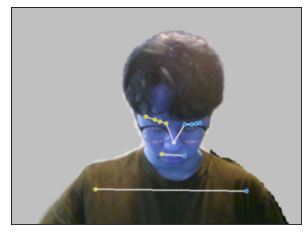

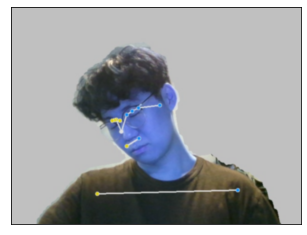

In [7]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# 이미지 파일 경로
IMAGE_FILES = ["test/img1.jpg", "test/img2.jpg"]
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    
    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)
    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.
    
    #mp_drawing.plot_landmarks(
     #   results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
    cv2.imwrite("test.jpg",annotated_image)
    check = cv2.imread("test.jpg")
    plt.imshow(check, interpolation='bicubic')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    cv2.waitKey(0)
    cv2.destroyAllWindows()



            


#### 어깨 위치 추출

In [8]:
def Shoulder_Point(result, image_width, image_height) :
    L_Shoulder_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width
    R_Shoulder_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width
    
    
    R_Shoulder_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
    L_Shoulder_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height
    
    return R_Shoulder_X, R_Shoulder_Y,L_Shoulder_X, L_Shoulder_Y

#### 목 위치 계산
* 잘 나온다!

In [9]:
def Compute_Neck(result, image_width, image_height) :
    L_Shoulder_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width
    R_Shoulder_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width
    Neck_X = (L_Shoulder_X + R_Shoulder_X) / float(2.0)
    
    R_Shoulder_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
    L_Shoulder_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height
    Neck_Y = (L_Shoulder_Y + R_Shoulder_Y) / float(2.0)

    return Neck_X, Neck_Y

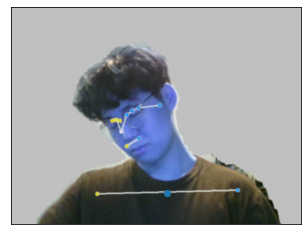

In [10]:
check = cv2.imread("test.jpg")
plt.imshow(check, interpolation='bicubic')
plt.xticks([])
plt.yticks([])
x,y = Compute_Neck(results, image_width, image_height)
plt.scatter(x,y)
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()

#### 코 위치 추출

In [11]:
def Nose_Point(result, image_width, image_height) :
    Nose_X = result.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width
    Nose_Y = result.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height

    return Nose_X, Nose_Y

#### 데이터 프레임 생성
* 사용할 Point는 코, 입, 눈 정도가 되겠다.
* 사실 코만 해도 될 것 같긴 하다.

In [12]:
def Point_by_MediaPipe(image_path, train_test, label):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    if train_test == "train":
        train_test = "train/"
    else:
        train_test = "test/"
    
    if label == "drowsy":
        label = "drowsy/"
    else:
        label = "notdrowsy/"
        
# For static images:
    IMAGE_FILES = image_path
    results = []
    BG_COLOR = (192, 192, 192) # gray
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
        for idx, file in enumerate(IMAGE_FILES):
            file = "pose/" + train_test + label + file

            image = cv2.imread(file)
            image_height, image_width, _ = image.shape
            results.append(pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

            if not results[idx].pose_landmarks:
                continue
                
            if idx % 10 == 0:
                print("전체 이미지 : %d / 완료한 이미지 %d" % (len(IMAGE_FILES), idx))
    print("---완료---")
    return results, image_height, image_width
            

    
    


        

In [13]:
drowsy_results, image_height, image_width = Point_by_MediaPipe(PATH_TRAIN_DROWSY_LIST, "train", "drowsy")
notdrowsy_results, image_height, image_width = Point_by_MediaPipe(PATH_TRAIN_NOTDROWSY_LIST, "train", "notdrowsy")

전체 이미지 : 150 / 완료한 이미지 0
전체 이미지 : 150 / 완료한 이미지 10
전체 이미지 : 150 / 완료한 이미지 20
전체 이미지 : 150 / 완료한 이미지 30
전체 이미지 : 150 / 완료한 이미지 40
전체 이미지 : 150 / 완료한 이미지 50
전체 이미지 : 150 / 완료한 이미지 60
전체 이미지 : 150 / 완료한 이미지 70
전체 이미지 : 150 / 완료한 이미지 80
전체 이미지 : 150 / 완료한 이미지 90
전체 이미지 : 150 / 완료한 이미지 100
전체 이미지 : 150 / 완료한 이미지 110
전체 이미지 : 150 / 완료한 이미지 120
전체 이미지 : 150 / 완료한 이미지 130
전체 이미지 : 150 / 완료한 이미지 140
---완료---
전체 이미지 : 150 / 완료한 이미지 0
전체 이미지 : 150 / 완료한 이미지 10
전체 이미지 : 150 / 완료한 이미지 20
전체 이미지 : 150 / 완료한 이미지 30
전체 이미지 : 150 / 완료한 이미지 40
전체 이미지 : 150 / 완료한 이미지 50
전체 이미지 : 150 / 완료한 이미지 60
전체 이미지 : 150 / 완료한 이미지 70
전체 이미지 : 150 / 완료한 이미지 80
전체 이미지 : 150 / 완료한 이미지 90
전체 이미지 : 150 / 완료한 이미지 100
전체 이미지 : 150 / 완료한 이미지 110
전체 이미지 : 150 / 완료한 이미지 120
전체 이미지 : 150 / 완료한 이미지 130
전체 이미지 : 150 / 완료한 이미지 140
---완료---


In [14]:
len(drowsy_results)

150

In [15]:
len(notdrowsy_results)

150

#### data frame 만들기
* null값 없이 잘 만들어 졌음

In [16]:
def Point_DataFrame(results, label):
    point_list = []
    if label == 0 or label == "notdrowsy":
        label = 0
    elif label == 1 or label == "drowsy":
        label = 1
    else:
        label = -1
    for result in results:
        temp = []
        Neck_X, Neck_Y = Compute_Neck(result, image_width, image_height)
        Nose_X, Nose_Y = Nose_Point(result, image_width, image_height)
        R_Shoulder_X, R_Shoulder_Y,L_Shoulder_X, L_Shoulder_Y = Shoulder_Point(result, image_width, image_height)
        temp.append(Neck_X)
        temp.append(Neck_Y)
        temp.append(Nose_X)
        temp.append(Nose_Y)
        temp.append(R_Shoulder_X)
        temp.append(R_Shoulder_Y)
        temp.append(L_Shoulder_X)
        temp.append(L_Shoulder_Y)
        temp.append(label)
        point_list.append(temp)
    dataframe = pd.DataFrame(columns = ["Neck_X", "Neck_Y", "Nose_X", "Nose_Y", "R_Shoulder_X", "R_Shoulder_Y","L_Shoulder_X", "L_Shoulder_Y", "label"],
                 data = point_list)
    return dataframe
    
        
        
    

In [17]:
train_data_drowsy = Point_DataFrame(drowsy_results, "drowsy")
train_data_notdrowsy = Point_DataFrame(notdrowsy_results, "notdrowsy")

In [18]:
train_data_drowsy

,Neck_X,Neck_Y,Nose_X,Nose_Y,R_Shoulder_X,R_Shoulder_Y,L_Shoulder_X,L_Shoulder_Y,label
0,352.593460,405.546985,359.448700,300.734196,186.123085,407.345095,519.063835,403.748875,1
1,353.336058,402.921710,360.591812,296.614666,191.096630,403.517017,515.575485,402.326403,1
2,349.346514,405.427709,361.746979,277.457228,182.484722,406.188955,516.208305,404.666462,1
3,356.568203,400.969849,351.641159,273.340874,193.945351,405.299120,519.191055,396.640577,1
4,351.677895,408.961272,360.864296,284.067020,185.350914,409.001255,518.004875,408.921289,1
...,...,...,...,...,...,...,...,...,...
145,326.053953,415.101142,392.638626,282.926044,174.036198,425.368338,478.071709,404.833946,1
146,330.534248,414.343772,385.325432,282.527332,178.158302,430.774956,482.910194,397.912588,1
147,331.800890,414.380236,380.240211,289.380169,177.308826,429.571581,486.292953,399.188890,1
148,326.532097,416.433663,386.659241,285.661068,170.135574,431.428270,482.928619,401.439056,1


In [19]:
train_data_notdrowsy

,Neck_X,Neck_Y,Nose_X,Nose_Y,R_Shoulder_X,R_Shoulder_Y,L_Shoulder_X,L_Shoulder_Y,label
0,325.075650,408.664212,331.005974,219.152012,149.900026,403.711739,500.251274,413.616686,0
1,336.582212,410.040464,338.224220,240.880737,156.523304,402.406797,516.641121,417.674131,0
2,354.847031,375.099378,352.181282,167.144794,165.808983,373.703356,543.885078,376.495399,0
3,353.279009,375.626936,346.461143,171.581554,165.460911,380.682564,541.097107,370.571308,0
4,356.667452,380.341287,342.199478,175.390491,164.538593,385.426483,548.796310,375.256090,0
...,...,...,...,...,...,...,...,...,...
145,357.191725,376.415019,377.770653,167.713566,168.191051,377.233629,546.192398,375.596409,0
146,357.626514,371.946716,357.205620,172.447300,170.391998,372.863159,544.861031,371.030273,0
147,353.261642,371.105089,340.752983,164.272556,167.403412,371.321468,539.119873,370.888710,0
148,352.953997,376.032057,350.864410,166.409054,161.153736,374.832401,544.754257,377.231712,0


In [20]:
train_data_drowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        150 non-null    float64
 1   Neck_Y        150 non-null    float64
 2   Nose_X        150 non-null    float64
 3   Nose_Y        150 non-null    float64
 4   R_Shoulder_X  150 non-null    float64
 5   R_Shoulder_Y  150 non-null    float64
 6   L_Shoulder_X  150 non-null    float64
 7   L_Shoulder_Y  150 non-null    float64
 8   label         150 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 10.7 KB


In [21]:
train_data_notdrowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        150 non-null    float64
 1   Neck_Y        150 non-null    float64
 2   Nose_X        150 non-null    float64
 3   Nose_Y        150 non-null    float64
 4   R_Shoulder_X  150 non-null    float64
 5   R_Shoulder_Y  150 non-null    float64
 6   L_Shoulder_X  150 non-null    float64
 7   L_Shoulder_Y  150 non-null    float64
 8   label         150 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 10.7 KB


#### 코 위치와 목 위치의 차이

In [22]:
def Compute_Diff(dataframe):
    dataframe["Diff_X"] = dataframe["Neck_X"] - dataframe["Nose_X"]
    dataframe["Diff_Y"] = dataframe["Neck_Y"] - dataframe["Nose_Y"]
    return dataframe

In [23]:
train_data_drowsy = Compute_Diff(train_data_drowsy)
train_data_notdrowsy = Compute_Diff(train_data_notdrowsy)

In [24]:
train_data_drowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        150 non-null    float64
 1   Neck_Y        150 non-null    float64
 2   Nose_X        150 non-null    float64
 3   Nose_Y        150 non-null    float64
 4   R_Shoulder_X  150 non-null    float64
 5   R_Shoulder_Y  150 non-null    float64
 6   L_Shoulder_X  150 non-null    float64
 7   L_Shoulder_Y  150 non-null    float64
 8   label         150 non-null    int64  
 9   Diff_X        150 non-null    float64
 10  Diff_Y        150 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 13.0 KB


In [25]:
train_data_notdrowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neck_X        150 non-null    float64
 1   Neck_Y        150 non-null    float64
 2   Nose_X        150 non-null    float64
 3   Nose_Y        150 non-null    float64
 4   R_Shoulder_X  150 non-null    float64
 5   R_Shoulder_Y  150 non-null    float64
 6   L_Shoulder_X  150 non-null    float64
 7   L_Shoulder_Y  150 non-null    float64
 8   label         150 non-null    int64  
 9   Diff_X        150 non-null    float64
 10  Diff_Y        150 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 13.0 KB


In [26]:
train_data_notdrowsy[['Neck_X','Nose_X', "Diff_X"]]

,Neck_X,Nose_X,Diff_X
0,325.075650,331.005974,-5.930324
1,336.582212,338.224220,-1.642008
2,354.847031,352.181282,2.665749
3,353.279009,346.461143,6.817865
4,356.667452,342.199478,14.467974
...,...,...,...
145,357.191725,377.770653,-20.578928
146,357.626514,357.205620,0.420895
147,353.261642,340.752983,12.508659
148,352.953997,350.864410,2.089586


#### 각도 계산
* Diff_X가 음수일 경우는 목의 X좌표가 코의 X좌표 보다 더 작음 => **코가 오른쪽, 즉 오른쪽으로 머리가 기울어진 상태**



* Diff_X가 양수일 경우는 목의 X좌표가 코의 X좌표 보다 더 큼 => **코가 왼쪽, 즉 왼쪽으로 머리가 기울어진 상태**


In [27]:
def Comput_Degree(dataframe):
    AB = np.sqrt((dataframe["Nose_X"] - dataframe["Neck_X"]) ** 2 
              + (dataframe["Nose_Y"] - dataframe["Neck_Y"]) ** 2)
    AC = np.abs(dataframe["Nose_X"] - dataframe["Neck_X"])
    cos = AC / AB
    degree = np.degrees(cos)
    dataframe.insert(0, "degree", degree, True)
    return dataframe

####  csv로 저장
* 필요없는 데이터는 삭제
* 일단 목, 코, 어깨 좌표 삭제
* 필요하다면 좌표들을 normalize하여서 사용해도 괜찮을듯?

In [28]:
train_data_drowsy = Comput_Degree(train_data_drowsy)
train_data_notdrowsy = Comput_Degree(train_data_notdrowsy)

In [29]:
train_data_drowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   degree        150 non-null    float64
 1   Neck_X        150 non-null    float64
 2   Neck_Y        150 non-null    float64
 3   Nose_X        150 non-null    float64
 4   Nose_Y        150 non-null    float64
 5   R_Shoulder_X  150 non-null    float64
 6   R_Shoulder_Y  150 non-null    float64
 7   L_Shoulder_X  150 non-null    float64
 8   L_Shoulder_Y  150 non-null    float64
 9   label         150 non-null    int64  
 10  Diff_X        150 non-null    float64
 11  Diff_Y        150 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 14.2 KB


In [32]:
train_data_notdrowsy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   degree        150 non-null    float64
 1   Neck_X        150 non-null    float64
 2   Neck_Y        150 non-null    float64
 3   Nose_X        150 non-null    float64
 4   Nose_Y        150 non-null    float64
 5   R_Shoulder_X  150 non-null    float64
 6   R_Shoulder_Y  150 non-null    float64
 7   L_Shoulder_X  150 non-null    float64
 8   L_Shoulder_Y  150 non-null    float64
 9   label         150 non-null    int64  
 10  Diff_X        150 non-null    float64
 11  Diff_Y        150 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 14.2 KB


In [38]:
train_data_drowsy = train_data_drowsy.drop(train_data_drowsy.columns[[1,2,3,4,5,6,7,8]], axis = 1)
train_data_notdrowsy = train_data_notdrowsy.drop(train_data_notdrowsy.columns[[1,2,3,4,5,6,7,8]], axis = 1)

In [44]:
train_data_drowsy = train_data_drowsy[['degree', 'Diff_X', 'Diff_Y', 'label']]
train_data_notdrowsy = train_data_notdrowsy[['degree', 'Diff_X', 'Diff_Y', 'label']]

In [45]:
train_data_drowsy

,degree,Diff_X,Diff_Y,label
0,3.739419,-6.855240,104.812789,1
1,3.901521,-7.255754,106.307044,1
2,5.526133,-12.400465,127.970481,1
3,2.210225,4.927044,127.628975,1
4,4.202948,-9.186401,124.894252,1
...,...,...,...,...
145,25.777300,-66.584673,132.175097,1
146,21.991573,-54.791183,131.816440,1
147,20.702839,-48.439322,125.000067,1
148,23.934946,-60.127144,130.772595,1


In [46]:
train_data_notdrowsy

,degree,Diff_X,Diff_Y,label
0,1.792055,-5.930324,189.512200,0
1,0.556135,-1.642008,169.159727,0
2,0.734408,2.665749,207.954583,0
3,1.913383,6.817865,204.045382,0
4,4.034608,14.467974,204.950795,0
...,...,...,...,...
145,5.622362,-20.578928,208.701453,0
146,0.120880,0.420895,199.499416,0
147,3.458771,12.508659,206.832533,0
148,0.571113,2.089586,209.623003,0


In [47]:
DataSet = pd.concat([train_data_drowsy, train_data_notdrowsy], ignore_index= True)

In [49]:
DataSet

,degree,Diff_X,Diff_Y,label
0,3.739419,-6.855240,104.812789,1
1,3.901521,-7.255754,106.307044,1
2,5.526133,-12.400465,127.970481,1
3,2.210225,4.927044,127.628975,1
4,4.202948,-9.186401,124.894252,1
...,...,...,...,...
295,5.622362,-20.578928,208.701453,0
296,0.120880,0.420895,199.499416,0
297,3.458771,12.508659,206.832533,0
298,0.571113,2.089586,209.623003,0


In [50]:
DataSet.to_csv("data/train_data.csv", index = False)

In [51]:
test = pd.read_csv("data/train_data.csv")

In [52]:
test

,degree,Diff_X,Diff_Y,label
0,3.739419,-6.855240,104.812789,1
1,3.901521,-7.255754,106.307044,1
2,5.526133,-12.400465,127.970481,1
3,2.210225,4.927044,127.628975,1
4,4.202948,-9.186401,124.894252,1
...,...,...,...,...
295,5.622362,-20.578928,208.701453,0
296,0.120880,0.420895,199.499416,0
297,3.458771,12.508659,206.832533,0
298,0.571113,2.089586,209.623003,0
